In [1]:
# append rxn_yield_context to the PYTHONPATH
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm
import pandas as pd
import torch
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Make the {reaxy_id: reaction class} pair dictionary
reaxys_dir = "../data/reaxys_input/"
dir_names = ['Buchwald-HartwigCross-Coupling','Chan_LamCoupling','DielsAlder', 'FischerIndoleSynthesis', 
             'Friedel-CraftsAcylation', 'Friedel-CraftsAlkylation', 'GrignardReaction',
             'KumadaCoupling', 'NegishiCoupling', 
             'ReductiveAmination'] # Change Here

reaction_name_convert_dict = {
    "Buchwald-HartwigCross-Coupling": "Buchwald-Hartwig cross-coupling",
    "Chan_LamCoupling": "Chan-Lam coupling", 
    "DielsAlder": "Diels-Alder reaction",
    "FischerIndoleSynthesis": "Fischer indole synthesis",
    "Friedel-CraftsAcylation": "Friedel-Crafts acylation",
    "Friedel-CraftsAlkylation": "Friedel-Crafts alkylation",
    "GrignardReaction": "Grignard reaction",
    "KumadaCoupling": "Kumada coupling",
    "NegishiCoupling": "Negishi coupling",
    "ReductiveAmination": "Reductive amination",
}

reaxys_id_dict = dict()

def basic_preprocess(data_path):
    keep_index = ['Reaction ID', 'Reaction', 'Temperature (Reaction Details) [C]', 
                  'Yield (numerical)','Reagent', 'Solvent (Reaction Details)']
    data = pd.read_excel(data_path)
    drop_index = list(data.columns)
    for index in list(data.columns):
        if index in keep_index:
            drop_index.remove(index)
    data = data.drop(drop_index,axis=1)
    data = data[:-3] # copyright or something 
    return data
    
file_path = os.path.join(reaxys_dir, dir_names[0])
# a = os.listdir(file_path)
for dir_name in tqdm(dir_names):
    file_path = os.path.join(reaxys_dir, dir_name)
    for i, file_name in enumerate(os.listdir(file_path)):
        if not file_name.endswith("xlsx"):
            continue
        data_path = os.path.join(file_path, file_name)
        reaction_set = basic_preprocess(data_path)
        for id_ in reaction_set['Reaction ID']:
            reaxys_id_dict.update({id_:dir_name})


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


In [3]:
reaxys_id_dict['35954576']

'ReductiveAmination'

In [4]:
# Get pre-processed data
from rxn_yield_context.preprocess_data import sort_out_data
def get_data(input_path):
    f = open(input_path, 'r',encoding="utf-8")
    data = f.readlines()
    f.close()
    return sort_out_data(data)

target_dir = "../data/reaxys_output"

train_data = get_data(os.path.join(os.path.join(target_dir, 'For_second_part_model'), 'Splitted_second_train_labels_processed.txt'))
validate_data = get_data(os.path.join(os.path.join(target_dir, 'For_second_part_model'), 'Splitted_second_validate_labels_processed.txt'))
test_data = get_data(os.path.join(os.path.join(target_dir, 'For_second_part_model'), 'Splitted_second_test_labels_processed.txt'))

print('Example of visualization:')
print(reaxys_id_dict[train_data[0][0]])
print(train_data[0])

Example of visualization:
DielsAlder
['8581089', 'O=C1C=CC(=O)C=C1.C=C1C(=C)[C@@]23COC4(CCCCC4)OC[C@@]12C(=C)C3=C', 'C=C1C(=C)[C@]23COC4(CCCCC4)OC[C@]12C1=C3CC2=C(C1)C(=O)C=CC2=O', [('55', '2,3-dicyano-5,6-dichloro-p-benzoquinone', 'benzene', '65.0')]]


In [5]:
# Get the trained first part model
import torch
from rxn_yield_context.train_multilabel.args_train import TrainArgs_rxn
from rxn_yield_context.train_multilabel.model_utils import Multitask_Multilabel

model_path = "../save_models/test_10R_first_local_10/multitask_model_epoch-80.checkpoint"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

state = torch.load(model_path, map_location= device)
args = TrainArgs_rxn()
args.from_dict(vars(state['args']), skip_unsettable=True)
args.device = device

loaded_state_dict = state['state_dict']
model = Multitask_Multilabel(args)
model.to(device)
model.load_state_dict(loaded_state_dict)
model.eval()


cpu


Multitask_Multilabel(
  (sigmoid): Sigmoid()
  (ffn_share): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (ffn_reagent): Sequential(
    (0): Linear(in_features=1024, out_features=300, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=300, out_features=1320, bias=True)
  )
  (ffn_solvent): Sequential(
    (0): Linear(in_features=1024, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=87, bias=True)
  )
  (criterion): FocalLoss()
)

In [6]:
# Get hidden output
from rxn_yield_context.train_multilabel.data_utils import create_rxn_Morgan2FP_concatenate


all_hidden = {'shared layer':{dir_name:[] for dir_name in dir_names},
              'reagent layer':{dir_name:[] for dir_name in dir_names},
              'solvent layer':{dir_name:[] for dir_name in dir_names}}
collected_hidden_shared = {dir_name:[] for dir_name in dir_names}
collected_hidden_solvent = {dir_name:[] for dir_name in dir_names}
collected_hidden_reagent = {dir_name:[] for dir_name in dir_names}
# all_hidden = []
for rxn in tqdm(test_data):
    try:
        reaction_type = reaxys_id_dict[rxn[0]]
    except:
        print(rxn[0])
        continue
    rxn_fp = torch.Tensor(create_rxn_Morgan2FP_concatenate(rxn[1], rxn[2], fpsize = args.fpsize, radius = args.radius))
    rxn_fp = rxn_fp.to(device)
    # shared layer
    hidden_output = model.ffn_share(rxn_fp).cpu().detach().numpy()
    all_hidden['shared layer'][reaction_type].append(hidden_output)
    # solvent layer
    hidden_output = model.ffn_solvent[1](model.ffn_solvent[0](model.ffn_share(rxn_fp))).cpu().detach().numpy() # solvent layer
    all_hidden['solvent layer'][reaction_type].append(hidden_output)
    # reagent layer
    hidden_output = model.ffn_reagent[1](model.ffn_reagent[0](model.ffn_share(rxn_fp))).cpu().detach().numpy() # reagent layer
    all_hidden['reagent layer'][reaction_type].append(hidden_output)
    
    # all_hidden.append(hidden_output)

# all_hidden = np.array(all_hidden)

100%|██████████| 7469/7469 [00:53<00:00, 138.85it/s]


In [ ]:
"""
# Perform PCA to reduce dimension 2-d
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(all_hidden)
print(pca.explained_variance_ratio_)

import pandas as pd
#pca.fit_transform()

plt.figure(dpi = 100)
for key, value in collected_hidden.items():
    if key in ['Hydrolysis', 'Diels_Alder', 'NegishiCouplings','GrignardReaction' , 'ReductiveAmination',
               'PausonKhandReaction', 'NegishiCouplings',
               'FischerIndoleSynthesis','Friedel-Crafts_Acylation','Friedel-Crafts_Alkylation']:
        df = pd.DataFrame(pca.fit_transform(np.array(value)))
        df['reaction class'] = [key]*len(value)
        plt.scatter(df[0], df[1],s=2, label=key)

plt.legend(loc='upper left',prop={'size': 6})
#df.head()
"""

In [7]:
# Perform t-sne:
from sklearn.manifold import TSNE
layer_names = ['shared layer', 'reagent layer', 'solvent layer']
X_tsne = dict()
for layer in layer_names:
    for i, (key, value) in enumerate(all_hidden[layer].items()):
        df_new = pd.DataFrame(np.array(value))
        df_new['reaction class'] = [key]*len(value)
        if i == 0:
            df = df_new.copy()
        else:
            df = df.append(df_new, ignore_index=True)

    X_tsne.update({layer: 
                   TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(df.values[:,:-1])})
    
    

/home/lungyi/anaconda3/envs/rxn_yield_context/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7469 samples in 0.004s...
[t-SNE] Computed neighbors for 7469 samples in 1.407s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7469
[t-SNE] Computed conditional probabilities for sample 2000 / 7469
[t-SNE] Computed conditional probabilities for sample 3000 / 7469
[t-SNE] Computed conditional probabilities for sample 4000 / 7469
[t-SNE] Computed conditional probabilities for sample 5000 / 7469
[t-SNE] Computed conditional probabilities for sample 6000 / 7469
[t-SNE] Computed conditional probabilities for sample 7000 / 7469
[t-SNE] Computed conditional probabilities for sample 7469 / 7469
[t-SNE] Mean sigma: 1.379068
[t-SNE] KL divergence after 250 iterations with early exaggeration: 117.564911
[t-SNE] KL divergence after 1000 iterations: 2.935206
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7469 samples in 0.001s...


/home/lungyi/anaconda3/envs/rxn_yield_context/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 7469 samples in 1.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7469
[t-SNE] Computed conditional probabilities for sample 2000 / 7469
[t-SNE] Computed conditional probabilities for sample 3000 / 7469
[t-SNE] Computed conditional probabilities for sample 4000 / 7469
[t-SNE] Computed conditional probabilities for sample 5000 / 7469
[t-SNE] Computed conditional probabilities for sample 6000 / 7469
[t-SNE] Computed conditional probabilities for sample 7000 / 7469
[t-SNE] Computed conditional probabilities for sample 7469 / 7469
[t-SNE] Mean sigma: 2.526352
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.670265
[t-SNE] KL divergence after 1000 iterations: 1.944387
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7469 samples in 0.000s...


/home/lungyi/anaconda3/envs/rxn_yield_context/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 7469 samples in 1.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7469
[t-SNE] Computed conditional probabilities for sample 2000 / 7469
[t-SNE] Computed conditional probabilities for sample 3000 / 7469
[t-SNE] Computed conditional probabilities for sample 4000 / 7469
[t-SNE] Computed conditional probabilities for sample 5000 / 7469
[t-SNE] Computed conditional probabilities for sample 6000 / 7469
[t-SNE] Computed conditional probabilities for sample 7000 / 7469
[t-SNE] Computed conditional probabilities for sample 7469 / 7469
[t-SNE] Mean sigma: 1.744079
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.498665
[t-SNE] KL divergence after 1000 iterations: 1.800627


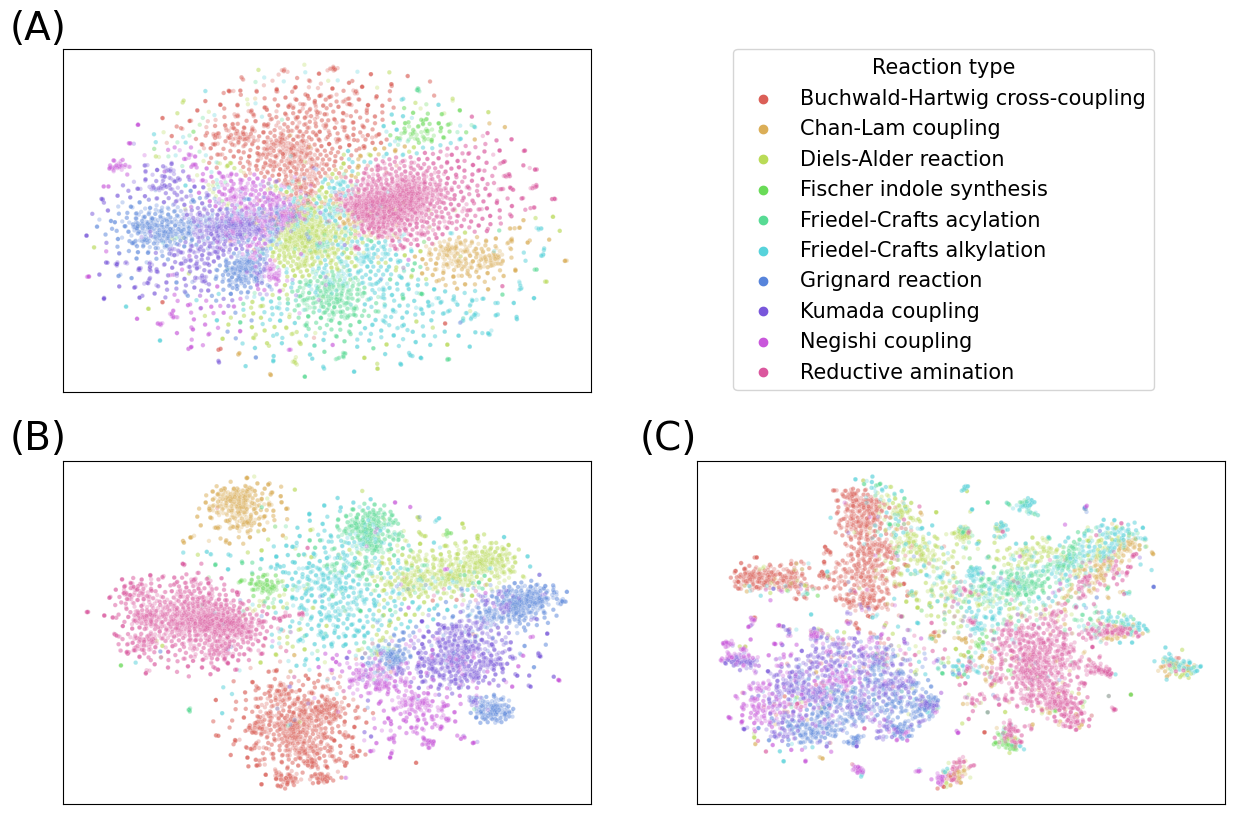

In [8]:
import seaborn as sns
import matplotlib
from matplotlib.font_manager import FontProperties

font_size = 15
font = {#'family' : 'normal',
        'weight' : 'normal',
        'size'   : font_size}

matplotlib.rc('font', **font)

layer_names = ['shared layer', 'reagent layer', 'solvent layer']
plt.figure(figsize=(15,10), dpi =100)

for i, layer in enumerate(layer_names):
    
    x_min, x_max = X_tsne[layer].min(0), X_tsne[layer].max(0)
    X_norm = (X_tsne[layer] - x_min) / (x_max - x_min)  #Normalize

    df_subset = pd.DataFrame()
    df_subset['tsne-2d-one (-)'] = X_norm[:, 0]
    df_subset['tsne-2d-two (-)'] = X_norm[:, 1]
    df_subset['reaction class'] = df['reaction class']
    df_subset = df_subset.replace(reaction_name_convert_dict)

    if i==0:
        plt.subplot(2,2,i+1)
    else:
        plt.subplot(2,2,i+2)
    sns.scatterplot(
        x="tsne-2d-one (-)", y="tsne-2d-two (-)",
        hue = 'reaction class',
        palette=sns.color_palette("hls", 10),
        data=df_subset,
        #legend="full",
        alpha=0.3,
        s=10
    )
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xticks([])
    plt.yticks([])
    fontP = FontProperties()
    fontP.set_size(font_size)
    if i == 0:
        legend = plt.legend(bbox_to_anchor=(1.25, 1.03), loc='upper left', prop=fontP, title='Reaction type')
        legend.get_title().set_fontsize(font_size)
    else:
        plt.legend('',frameon=False)

plt.figtext(0.09, 0.89, "(A)", fontsize=28)
plt.figtext(0.09, 0.48, "(B)", fontsize=28)
plt.figtext(0.51, 0.48, "(C)", fontsize=28)
plt.savefig('../saved_figures/tsne_embeddings.png', format="png",bbox_inches = "tight")